In [258]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label, distance_transform_edt, percentile_filter, gaussian_filter1d
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import dijkstra

In [334]:
fringe = np.loadtxt('./experiments/static-effective-pressure/outputs/fringe_Pw_95_pct.txt')
disp = np.loadtxt('./experiments/static-effective-pressure/outputs/dispersed_Pw_95_pct.txt')

fringe = np.flip(fringe.reshape(328, 274), axis = 0)
disp = np.flip(disp.reshape(328, 274), axis = 0)

masked_array = np.ma.masked_not_equal(fringe, 1e-6)
disp = masked_array.mask * disp

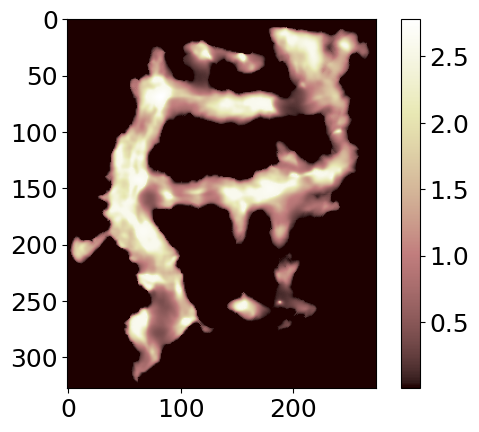

In [335]:
im = plt.imshow(fringe, cmap = 'pink')
plt.colorbar(im)
plt.show()

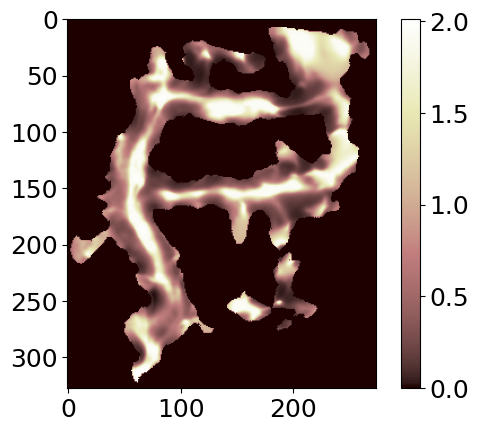

In [336]:
im = plt.imshow(disp, cmap = 'pink')
plt.colorbar(im)
plt.show()

In [337]:
dist = distance_transform_edt(masked_array.mask)
filter = np.ones((9, 9))
center = dist > percentile_filter(dist, 70, footprint = filter)

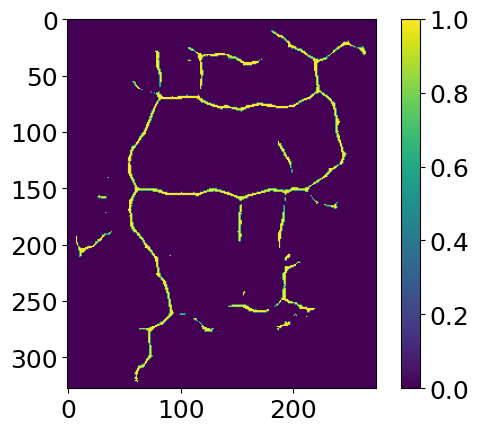

In [338]:
im = plt.imshow(center)
plt.colorbar(im)
plt.show()

In [339]:
labeled, n_labels = label(center)
sizes = np.bincount(labeled.ravel())[1:]
group = np.where(
    labeled == np.argmax(sizes) + 1,
    1,
    0,
)

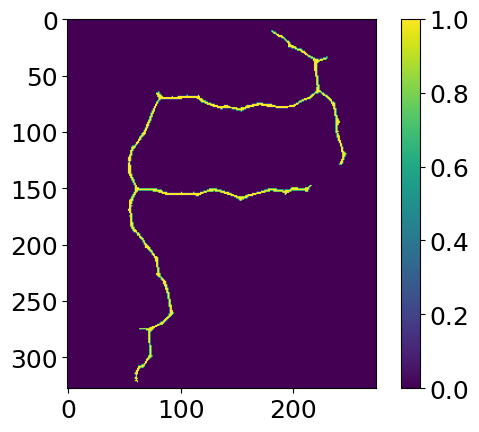

In [340]:
im = plt.imshow(group)
plt.colorbar(im)
plt.show()

In [341]:
selection = np.argmax(group * np.indices(group.shape)[0])
x0 = np.ravel(np.indices(group.shape)[0])[selection]
y0 = np.ravel(np.indices(group.shape)[1])[selection]
print(x0, y0)

322 62


In [342]:
def build_adjacency_matrix(coords):
    num_points = len(coords)
    adjacency_matrix = np.zeros((num_points, num_points), dtype=float)

    for i in range(num_points):
        for j in range(i + 1, num_points):
            # Calculate the Euclidean distance between the points
            distance = np.linalg.norm(coords[i] - coords[j])

            # Update the adjacency matrix
            adjacency_matrix[i, j] = distance
            adjacency_matrix[j, i] = distance

    return adjacency_matrix

region = np.argwhere(group == 1)
adj = build_adjacency_matrix(region)

In [343]:
sparse = csr_matrix(adj)
distance, _ = dijkstra(sparse, indices = [y0, x0])

indices = np.nonzero(group)
dist = np.zeros_like(group)
dist[indices] = np.max(distance) - distance

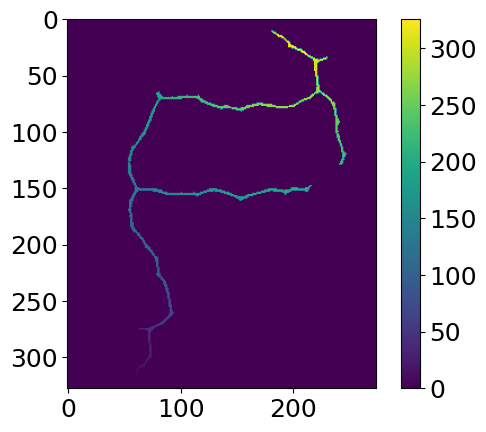

In [344]:
im = plt.imshow(dist)
plt.colorbar(im)
plt.show()

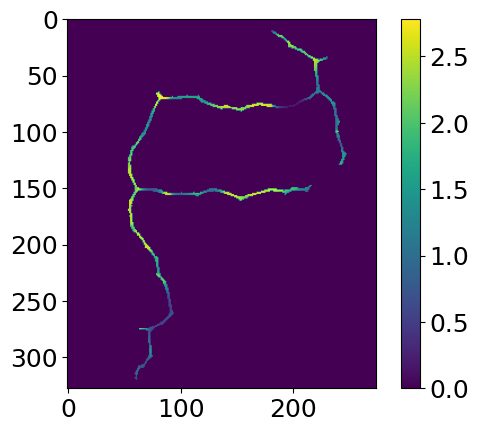

In [345]:
fringe_masked = np.where(dist > 0, fringe, 0)
im = plt.imshow(fringe_masked)
plt.colorbar(im)
plt.show()

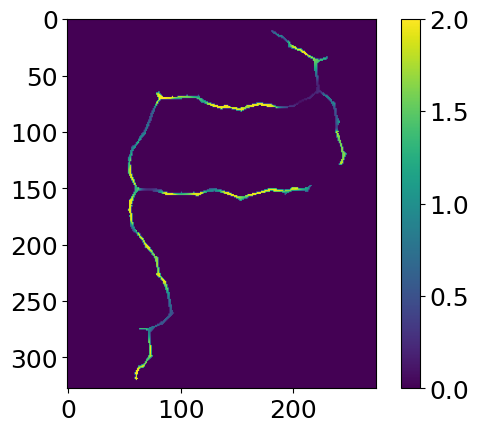

In [346]:
disp_masked = np.where(dist > 0, disp, 0)
im = plt.imshow(disp_masked)
plt.colorbar(im)
plt.show()

In [347]:
bins = np.arange(5, 350, 0.1)
fvals = np.zeros_like(bins)
dvals = np.zeros_like(bins)

for i in range(len(bins)):
    if i != 0:
        mn = bins[i - 1]
    else:
        mn = 0
    mx = bins[i]
    
    all_fvals = fringe_masked[(dist != 0) & (dist <= mx) & (dist >= mn)]

    if len(all_fvals > 0):
        fvals[i] = np.mean(all_fvals)
    else:
        fvals[i] = 0

    all_dvals = disp_masked[(dist != 0) & (dist <= mx) & (dist >= mn)]

    if len(all_dvals > 0):
        dvals[i] = np.mean(all_dvals)
    else:
        dvals[i] = 0

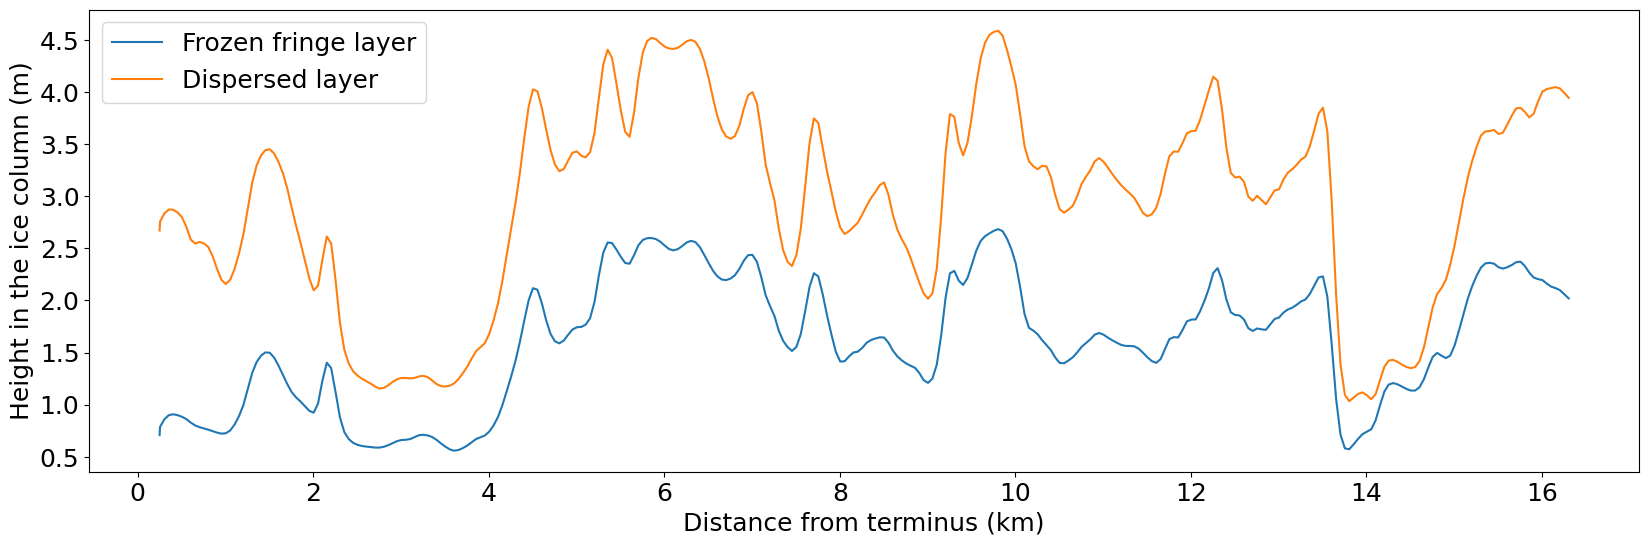

In [348]:
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(figsize = (20, 6))

mask = (fvals != 0) & (dvals != 0)

ax.plot(bins[mask] * 50 / 1e3, gaussian_filter1d(fvals[mask], sigma = 1), label = 'Frozen fringe layer')
ax.plot(bins[mask] * 50 / 1e3, gaussian_filter1d(dvals[mask] + fvals[mask], sigma = 1), label = 'Dispersed layer')

plt.legend(loc = 'upper left')
plt.xlabel('Distance from terminus (km)')
plt.ylabel('Height in the ice column (m)')
# plt.annotate('Shown with ~300x vertical exaggeration', [10, 0])
plt.show()